In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
FIG2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/final_object/figures/forpaper/Similarity_JaccardIndex/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
pop_tme = "Endothelial" # cell type to compare

In [4]:
# load mCRC data
adata_met = sc.read_h5ad("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/prepareInputRNA/Multiome_Che_Wu_CRC_LM_annotations_raw.h5ad")
adata_met = adata_met[adata_met.obs.Annotation_scVI==pop_tme].copy()
print(adata_met.shape)
    
# load pCRC data
adata_p = sc.read_h5ad("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/SMC_KUL_Pelka_Che_Wu_pCRC_annotations_raw.h5ad")
adata_p = adata_p[adata_p.obs.Annotation_scVI==pop_tme].copy()
print(adata_p.shape)


(557, 39559)
(3047, 39609)


In [5]:
adata_met

AnnData object with n_obs × n_vars = 557 × 39559
    obs: 'Patient', 'Sample', 'Tissue', 'Therapy', 'cell_source', 'Annotation_scVI', 'Annotation_scVI_detailed', 'Annotation_source', 'technology'
    var: 'n_cells-Nasrine', 'n_cells'

In [6]:
adata_p

AnnData object with n_obs × n_vars = 3047 × 39609
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'Annotation_scVI_detailed'
    var: 'n_cells_by_counts-Che', 'total_counts-Che', 'mean_counts-Che', 'pct_dropout_by_counts-Che', 'n_cells_by_counts-KUL', 'total_counts-KUL', 'mean_counts-KUL', 'pct_dropout_by_counts-KUL', 'n_cells_by_counts-Pelka', 'total_counts-Pelka', 'mean_counts-Pelka', 'pct_dropout_by_counts-Pelka', 'n_cells_by_counts-SMC', 'total_counts-SMC', 'mean_counts-SMC', 'pct_dropout_by_counts-SMC', 'n_cells_by_counts-Wu', 'total_counts-Wu', 'mean_counts-Wu', 'pct_dropout_by_counts-Wu', 'n_cells'
    uns: 'Therapy_colors', 'Tissue_colors', 'cell_source_colors'

### Normalise + log transform 

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [7]:
# keep raw
adata_met.layers["raw"] = adata_met.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata_met, target_sum=1e4, inplace=True)
adata_met.layers["normalised"] = adata_met.X.copy()
sc.pp.log1p(adata_met)

adata_met.layers["log1p"] = adata_met.X.copy()

adata_met.raw = adata_met  # keep normalised log1p

In [8]:
# keep raw
adata_p.layers["raw"] = adata_p.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata_p, target_sum=1e4, inplace=True)
adata_p.layers["normalised"] = adata_p.X.copy()
sc.pp.log1p(adata_p)

adata_p.layers["log1p"] = adata_p.X.copy()

adata_p.raw = adata_p  # keep normalised log1p

In [9]:
# issue here https://github.com/theislab/single-cell-tutorial/issues/97
# This seems to be a scanpy bug as you can see here and here. The latter issue suggests to just add the line:
# adata.uns['log1p']["base"] = None after reading again, or downgrading to AnnData<0.8.
# Either way, this should be fixed soon by the maintenance team.
adata_met.uns["log1p"]["base"] = None
adata_p.uns["log1p"]["base"] = None

### Differential expression to get DE genes upregulated 

In [10]:
sc.tl.rank_genes_groups(
    adata_met,
    groupby="Annotation_scVI_detailed",
    reference="rest",
    method="wilcoxon",
    use_raw=True,
    layer=None,
    pts=True,
    corr_method="benjamini-hochberg",
    key_added="rank_genes_wilcoxon",
)

sc.tl.rank_genes_groups(
    adata_p,
    groupby="Annotation_scVI_detailed",
    reference="rest",
    method="wilcoxon",
    use_raw=True,
    layer=None,
    pts=True,
    corr_method="benjamini-hochberg",
    key_added="rank_genes_wilcoxon",
)

In [11]:
pval_thresh = 0.05
log2fc_thresh = 1

cluster_de_genes_met = dict()
for cluster in sorted(set(adata_met.obs["Annotation_scVI_detailed"])):
    cluster_de_genes_met[cluster] = sc.get.rank_genes_groups_df(
        adata_met,
        group=cluster,
        key="rank_genes_wilcoxon",
        pval_cutoff=pval_thresh,
        log2fc_min=log2fc_thresh,
        log2fc_max=None,
    ).sort_values("logfoldchanges", ascending=False)


In [12]:
cluster_de_genes_p = dict()
for cluster in sorted(set(adata_p.obs["Annotation_scVI_detailed"])):
    cluster_de_genes_p[cluster] = sc.get.rank_genes_groups_df(
        adata_p,
        group=cluster,
        key="rank_genes_wilcoxon",
        pval_cutoff=pval_thresh,
        log2fc_min=log2fc_thresh,
        log2fc_max=None,
    ).sort_values("logfoldchanges", ascending=False)


# Use jaccard index to assess how similar TME populations are in pCRC and mCRC

To investigate if some TME populations were actually shared by both tumour sites, we appliedthe pair-wised Jaccard index calculated as follows, where A and B represent two TME subpopulations.

 Jaccard index = A⋂B/A⋃B
 
 Jaccard Similarity also known as Jaccard index, is a statistic to measure the similarity between two data sets. It is measured as the size of the intersection of two sets divided by the size of their union.

Where:

    |A \cap B| is the cardinality (size) of the intersection of sets A and B.
    |A\cup B| is the cardinality (size) of the union of sets A and B.

Jaccard Similarity is also known as the Jaccard index or Jaccard coefficient, its values lie between 0 and 1. where 0 means no similarity and the values get closer to 1 means increasing similarity 1 means the same datasets.

1. compute DE genes and compute intersection and union

In [13]:
# create a dataframe with rows from primary and cols from met
jacc_idx_df = pd.DataFrame(index=adata_p.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
                           columns=adata_met.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
                           dtype=float
                          )
jacc_idx_df

,Lymphatic endo,SEC,Stalk-like endo,Tip-like endo
Endo cycling,NaN,NaN,NaN,NaN
Lymphatic endo,NaN,NaN,NaN,NaN
Stalk-like endo,NaN,NaN,NaN,NaN
Tip-like endo,NaN,NaN,NaN,NaN


In [14]:
# compute jaccard index for a pair
def jaccard_index(a, b):
    nb_obs_intersection = len(set(a).intersection(set(b)))
    nb_obs_union = len(set(a).union(set(b)))
    
    return  nb_obs_intersection/nb_obs_union

In [15]:
a = [1, 2, 4, 5, 6]
b = [1, 2, 3, 7, 8]

jaccard_index(a, b)

0.25

In [16]:
a = ["Lion" , "Tiger" , "Cheetah" , "Leopard" , "Rhino"]
b = ["Lion" , "Monkey" , "Cheetah" , "Cat" , "Dog"]

jaccard_index(a, b)

0.25

In [17]:

a = {1,2,3,4,6}
b = {1,2,5,8,9}
jaccard_index(a, b)

0.25

In [30]:
# how many genes to consider? 
genes2consider = 200
# compute jaccard index
for p in jacc_idx_df.index:
    for m in jacc_idx_df.columns:
        jacc_idx_df.loc[p,m] = jaccard_index(a=cluster_de_genes_p[p]['names'][:genes2consider],
                                             b=cluster_de_genes_met[m]['names'][:genes2consider])

In [31]:
jacc_idx_df

,Lymphatic endo,SEC,Stalk-like endo,Tip-like endo
Endo cycling,0.000000,0.002506,0.000000,0.000000
Lymphatic endo,0.179941,0.036269,0.000000,0.002506
Stalk-like endo,0.025641,0.038961,0.014218,0.007557
Tip-like endo,0.002506,0.010101,0.000000,0.230769


There are many advantages of using Jaccard Similarity:

   * It is simple to calculate.
   * It is unaffected by the size of dataset.
   * It is a reliable option for determining similarity when the sets are of various sizes.
   * It may be used to compare the similarity of any kind of data, including time series data, photos, text, and images.

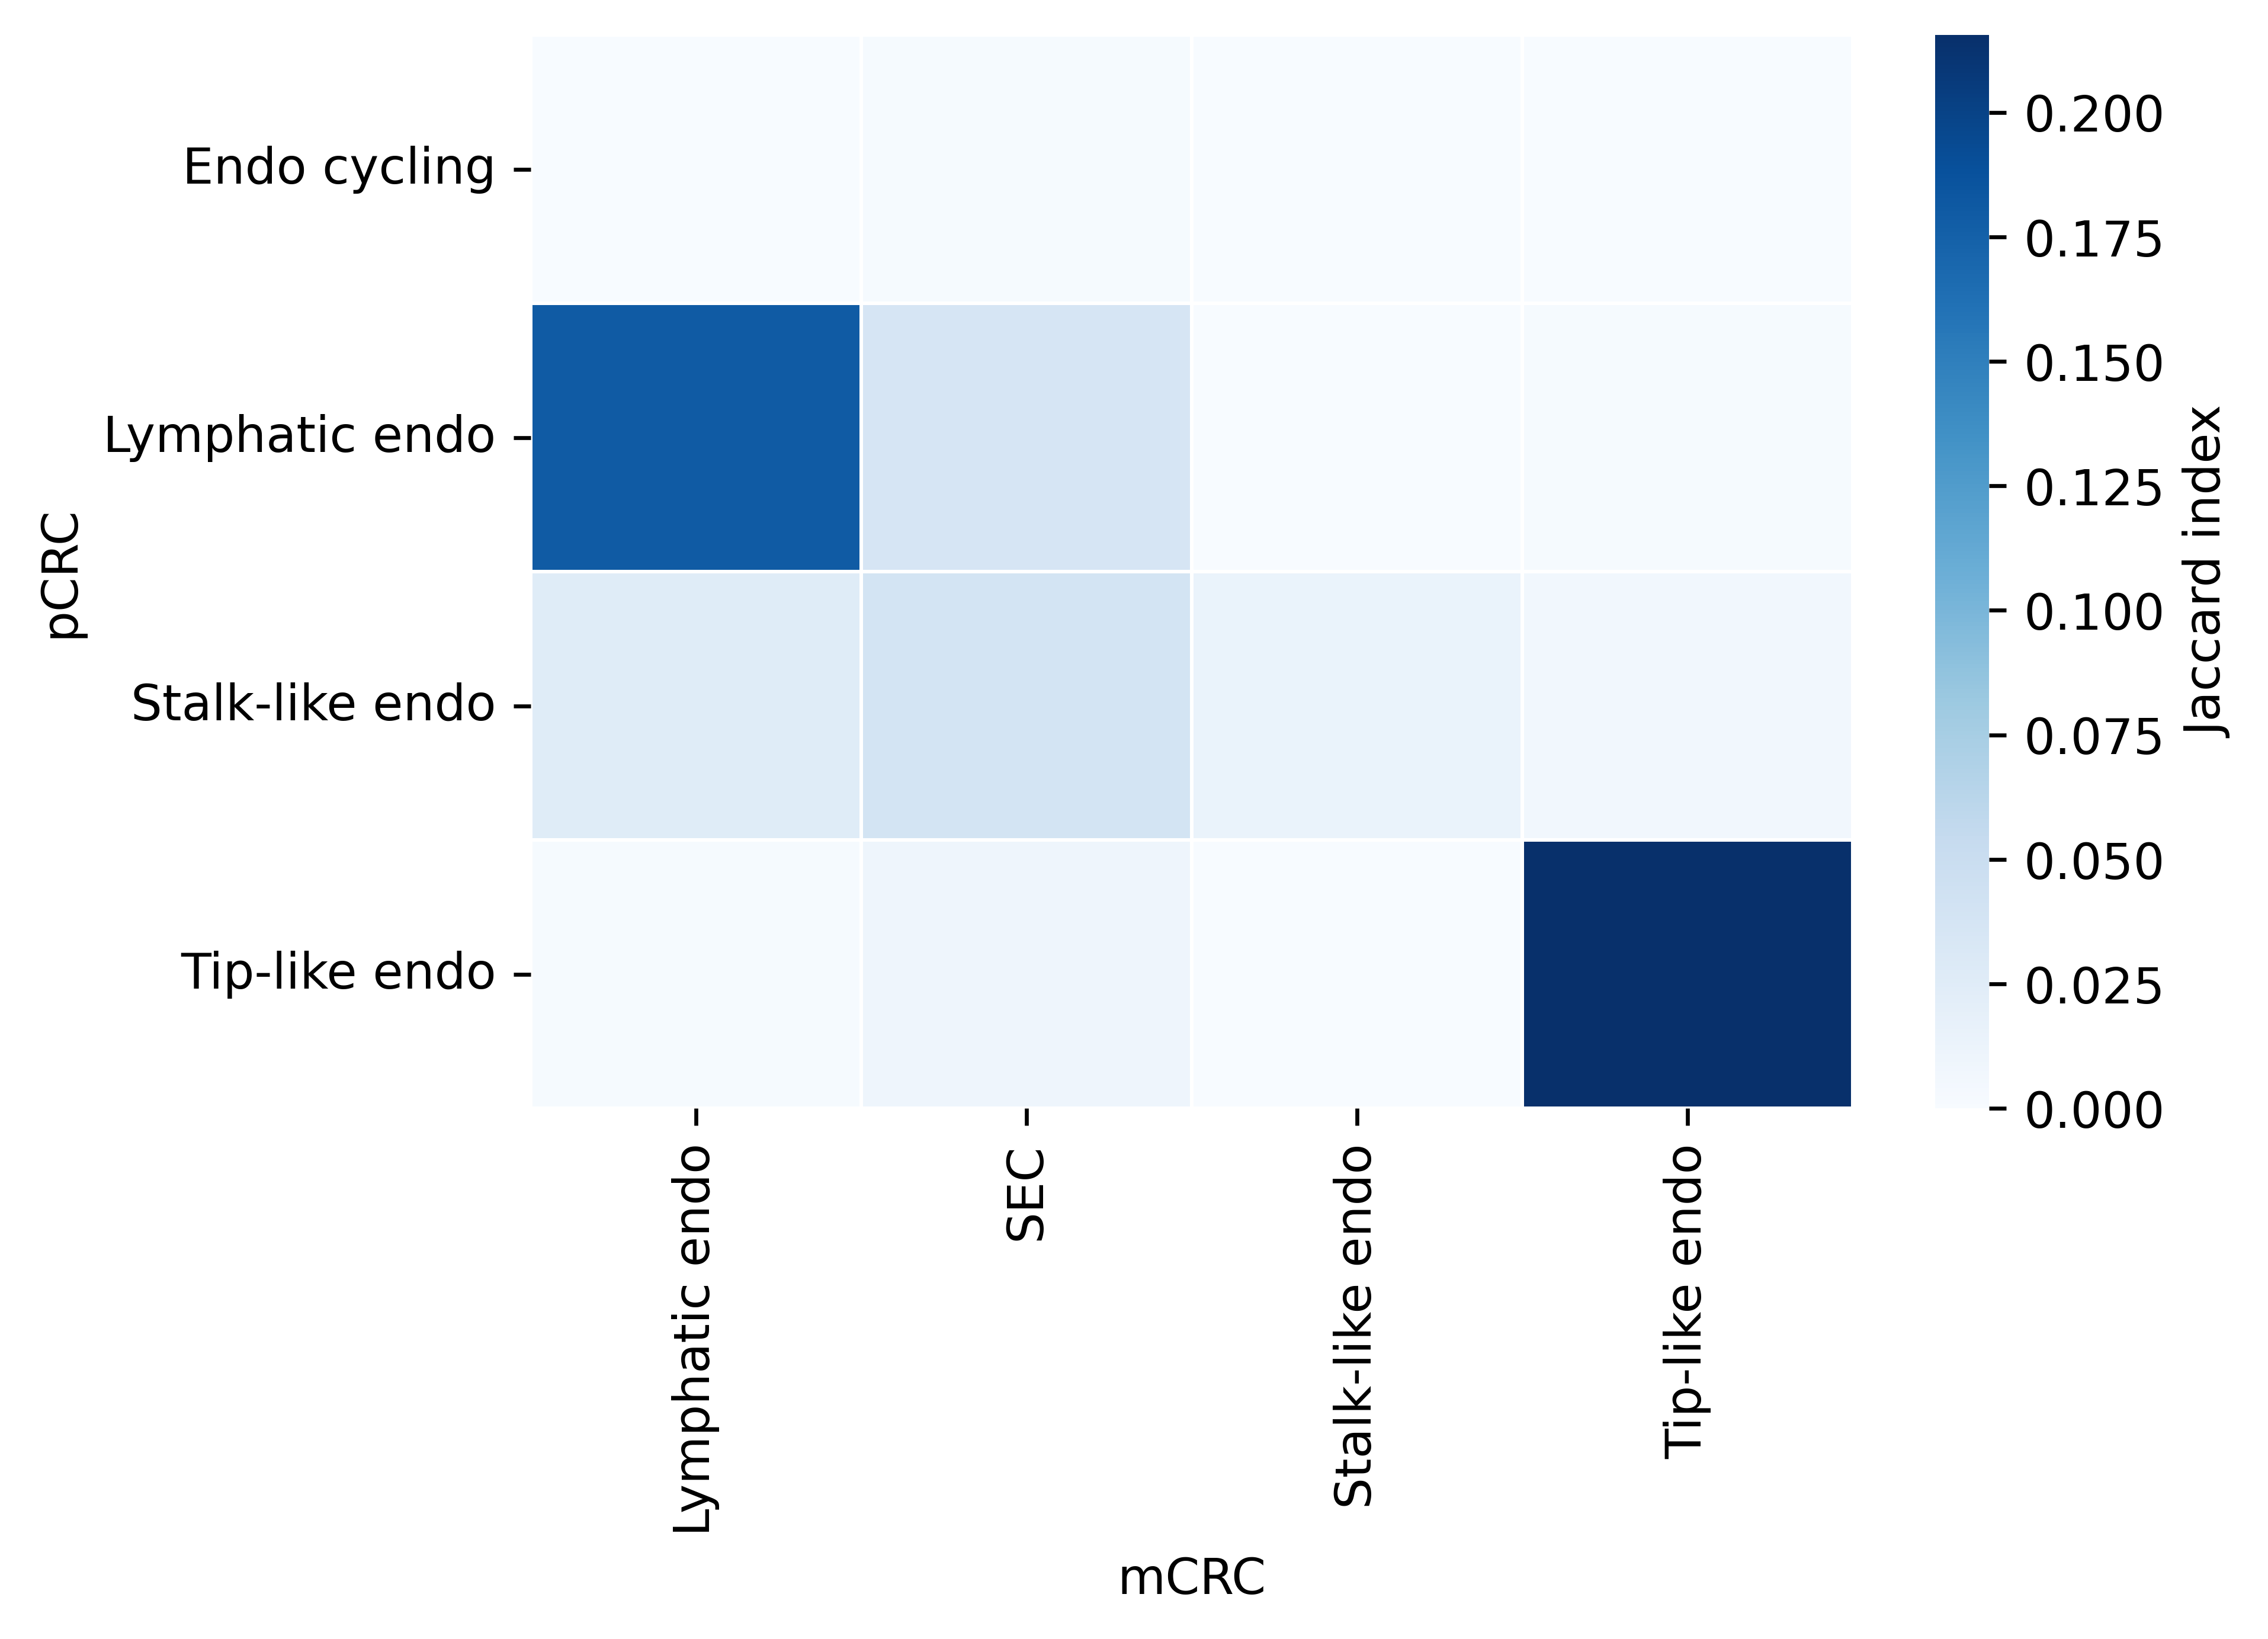

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=DPI)

sns.heatmap(data=jacc_idx_df,
            cmap='Blues',
            robust=True,
            cbar_kws={'label': 'Jaccard index'}, 
            linewidths=.5,
            ax=ax
           )
ax.set_ylabel('pCRC')
ax.set_xlabel('mCRC')

fig.savefig(FIG2SAVE.joinpath(f"Jaccard_index_{pop_tme}_{genes2consider}_DE_genes_per_subpop.pdf"), 
            dpi=DPI, 
            format="pdf",
            bbox_inches="tight")

In [33]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/final_object/figures/forpaper/Similarity_JaccardIndex')